# FINMA Python Lab 11: Adding Government Bonds to Portfolio Optimization

## Overview

In this lab, you'll extend the multi-asset portfolio optimization framework to include **government bonds** as a diversification asset. Government bonds (especially long-term treasuries) often have **negative correlations** with equities, making them powerful diversifiers during market stress.

### What You'll Learn:
1. How to add a new asset class to an existing portfolio
2. How to work with correlation matrices
3. The impact of negative correlations on portfolio efficiency
4. How bonds change the risk-return trade-off

### Learning Objectives:
- Extend arrays with new data (returns, volatilities)
- Expand correlation matrices properly
- Understand matrix operations (vstack, hstack)
- Analyze the diversification benefits of bonds

**Prerequisites:** 
- Completed the main lecture on Markowitz Portfolio Theory
- Understanding of NumPy arrays and matrix operations
- Familiarity with the MultiAssetOptimisation class

**Important:** Complete your work and have it manually checked by your instructor.

---

## Setup: Import Libraries and Define the Optimization Class

First, we'll import the necessary libraries and set up our optimization class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## The MultiAssetOptimisation Class

This is the same class from the lecture. **You don't need to modify this** - just run it to make it available.

In [2]:
class MultiAssetOptimisation:
    """
    Multi-asset portfolio optimization using Monte Carlo simulation.
    """
    ALPHA = 0.3  # Dirichlet concentration parameter
    
    def __init__(self, returns, volatilities, corr_matrix, asset_names, 
                 num_portfolios=50000, risk_free_rate=0.04, weighting_style='normalised'):
        self.returns = np.array(returns)
        self.volatilities = np.array(volatilities)
        self.corr_matrix = np.array(corr_matrix)
        self.asset_names = asset_names
        self.num_portfolios = num_portfolios
        self.risk_free_rate = risk_free_rate
        self.weighting_style = weighting_style
        
        # Create covariance matrix from correlation and volatilities
        self.cov_matrix = self.corr_matrix * np.outer(self.volatilities, self.volatilities)
    
    def _get_weights(self):
        n = len(self.returns)
        
        if self.weighting_style == 'normalised':
            weights = np.random.random((self.num_portfolios, n))
            weights = weights / weights.sum(axis=1, keepdims=True)
        
        elif self.weighting_style == 'dirichlet':
            weights = np.random.dirichlet(self.ALPHA * np.ones(n), size=self.num_portfolios)
        
        elif self.weighting_style == 'constrain-assets':
            weights = []
            for _ in range(self.num_portfolios):
                w = np.zeros(n)
                i, j = np.random.choice(n, size=2, replace=False)
                vals = np.random.random(2)
                vals /= vals.sum()
                w[i], w[j] = vals
                weights.append(w)
            weights = np.array(weights)
        
        else:
            raise ValueError("Invalid weighting_style.")
        
        return weights
    
    def plot_efficient_frontier(self):
        weights = self._get_weights()
        
        portfolio_returns = weights @ self.returns
        portfolio_vols = np.array([
            np.sqrt(w.T @ self.cov_matrix @ w) for w in weights
        ])
        sharpe_ratios = (portfolio_returns - self.risk_free_rate) / portfolio_vols
        
        # Optimal portfolios
        max_sharpe_idx = np.argmax(sharpe_ratios)
        min_vol_idx = np.argmin(portfolio_vols)
        
        # Plot
        plt.figure(figsize=(14, 10))
        scatter = plt.scatter(portfolio_vols, portfolio_returns, 
                            c=sharpe_ratios, cmap='viridis', alpha=0.5, s=10)
        plt.colorbar(scatter).set_label('Sharpe Ratio')
        
        # Optimal points
        plt.scatter(portfolio_vols[max_sharpe_idx], portfolio_returns[max_sharpe_idx], 
                   c='red', marker='*', s=300, label='Maximum Sharpe')
        plt.scatter(portfolio_vols[min_vol_idx], portfolio_returns[min_vol_idx], 
                   c='green', marker='*', s=300, label='Minimum Volatility')
        
        # Plot individual assets
        for i, name in enumerate(self.asset_names):
            plt.scatter(self.volatilities[i], self.returns[i], 
                       s=100, marker='D', edgecolors='black', linewidths=2)
            plt.annotate(name, (self.volatilities[i], self.returns[i]), 
                        fontsize=9, alpha=0.7, ha='right')
        
        plt.xlabel('Volatility (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print optimal portfolios
        print("-" * 50)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        for i, name in enumerate(self.asset_names):
            print(f"{name}: {weights[max_sharpe_idx][i]*100:.2f}%")
        print(f"Expected Return: {portfolio_returns[max_sharpe_idx]*100:.2f}%")
        print(f"Expected Volatility: {portfolio_vols[max_sharpe_idx]*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_idx]:.2f}")
        
        print("\n" + "-" * 50)
        print("Minimum Volatility Portfolio Allocation\n")
        for i, name in enumerate(self.asset_names):
            print(f"{name}: {weights[min_vol_idx][i]*100:.2f}%")
        print(f"Expected Return: {portfolio_returns[min_vol_idx]*100:.2f}%")
        print(f"Expected Volatility: {portfolio_vols[min_vol_idx]*100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratios[min_vol_idx]:.2f}")

---

## Part 1: Baseline Portfolio (Equity Sectors Only)

First, let's establish a baseline by running the optimization with **only equity sectors** (no bonds yet).

This will give us a reference point to compare against when we add government bonds.

In [3]:
# Define the 10 equity sectors
sectors = [
    "Energy", "Materials", "Industrials", "Consumer Discretionary",
    "Consumer Staples", "Health Care", "Financials", "Information Technology",
    "Telecom", "Utilities"
]

# Expected annual returns (as decimals, e.g., 0.0877 = 8.77%)
sector_returns = np.array([0.0877, 0.0983, 0.1203, 0.1312, 0.0761,
                           0.1112, 0.0726, 0.1493, 0.0942, 0.0829])

# Annual volatilities (standard deviations)
sector_volatilities = np.array([0.20, 0.22, 0.18, 0.19, 0.13,
                                0.15, 0.20, 0.27, 0.21, 0.15])

# Correlation matrix (10x10)
sector_corr = np.array([
    [1.00, 0.72, 0.62, 0.49, 0.36, 0.37, 0.51, 0.41, 0.33, 0.52],
    [0.72, 1.00, 0.78, 0.71, 0.51, 0.43, 0.65, 0.52, 0.40, 0.38],
    [0.62, 0.78, 1.00, 0.88, 0.63, 0.60, 0.83, 0.69, 0.55, 0.43],
    [0.49, 0.71, 0.88, 1.00, 0.60, 0.57, 0.80, 0.75, 0.46, 0.33],
    [0.36, 0.51, 0.63, 0.60, 1.00, 0.64, 0.68, 0.35, 0.45, 0.42],
    [0.37, 0.43, 0.60, 0.57, 0.64, 1.00, 0.61, 0.53, 0.46, 0.43],
    [0.51, 0.65, 0.83, 0.80, 0.68, 0.61, 1.00, 0.52, 0.49, 0.43],
    [0.41, 0.52, 0.69, 0.75, 0.35, 0.53, 0.52, 1.00, 0.49, 0.17],
    [0.33, 0.40, 0.55, 0.46, 0.45, 0.46, 0.49, 0.49, 1.00, 0.28],
    [0.52, 0.38, 0.43, 0.33, 0.42, 0.43, 0.43, 0.17, 0.28, 1.00],
])

print("Baseline data loaded successfully!")
print(f"Number of sectors: {len(sectors)}")
print(f"Correlation matrix shape: {sector_corr.shape}")

Baseline data loaded successfully!
Number of sectors: 10
Correlation matrix shape: (10, 10)


### Run Baseline Optimization

Let's see what the efficient frontier looks like with **only equity sectors**.

BASELINE: Equity Sectors Only



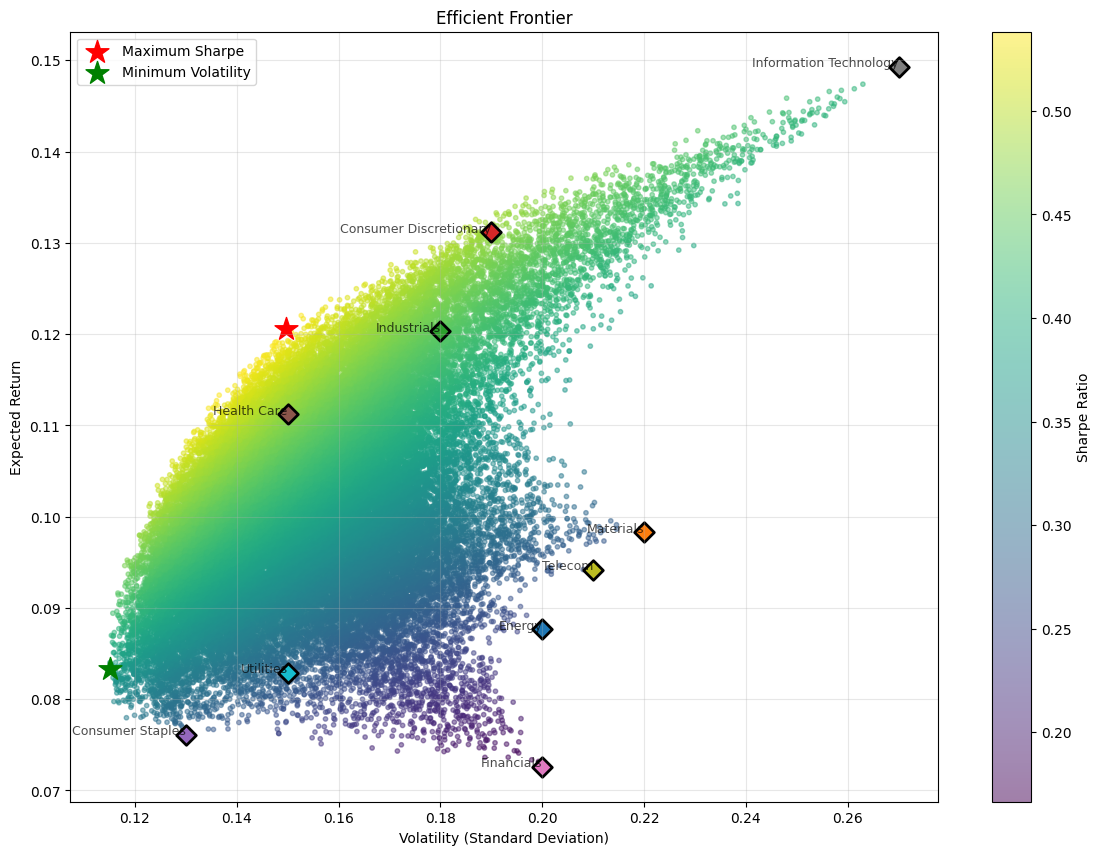

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Energy: 0.45%
Materials: 0.10%
Industrials: 0.02%
Consumer Discretionary: 49.98%
Consumer Staples: 0.04%
Health Care: 42.26%
Financials: 0.06%
Information Technology: 2.14%
Telecom: 0.51%
Utilities: 4.44%
Expected Return: 12.05%
Expected Volatility: 14.96%
Sharpe Ratio: 0.54

--------------------------------------------------
Minimum Volatility Portfolio Allocation

Energy: 3.75%
Materials: 0.70%
Industrials: 0.01%
Consumer Discretionary: 0.02%
Consumer Staples: 53.56%
Health Care: 4.80%
Financials: 0.00%
Information Technology: 2.92%
Telecom: 4.53%
Utilities: 29.73%
Expected Return: 8.34%
Expected Volatility: 11.50%
Sharpe Ratio: 0.38


In [4]:
# Create optimizer with equity sectors only
opt_baseline = MultiAssetOptimisation(
    sector_returns, 
    sector_volatilities, 
    sector_corr, 
    sectors, 
    weighting_style='dirichlet'
)

# Plot the efficient frontier
print("BASELINE: Equity Sectors Only\n")
opt_baseline.plot_efficient_frontier()

**Important:** Take note of the Maximum Sharpe Ratio and Minimum Volatility values. We'll compare these after adding bonds!

---

## Part 2: Adding Government Bonds - Step by Step

Now comes the main part of this lab. You'll add **Long-Term US Treasury Bonds (TLT)** to the portfolio.

### Government Bond Characteristics:

- **Asset:** Long-Term US Treasuries (TLT - iShares 20+ Year Treasury Bond ETF)
- **Expected Return:** 5.0% annually (lower than equities)
- **Volatility:** 12% annually (lower than most equities)
- **Key Feature:** **Negative correlation with equities** (bonds often rise when stocks fall)

### Why This Matters:

Government bonds typically have **negative correlations** with equity sectors because:
- When economic growth slows → stocks fall, bonds rise (flight to safety)
- When interest rates fall → bond prices rise, growth stocks may fall
- During market stress → investors seek safety in government bonds

This negative correlation is the key to diversification benefits!

---

### Exercise 1: Add TLT to the Sectors List

**Task:** Extend the `sectors` list to include "Long-Term Treasuries (TLT)" as the 11th asset.

**Hint:** You can use the `.append()` method on a list, or create a new list with all 11 items.

**Expected Result:** `sectors` should now have 11 elements instead of 10.

In [5]:
# Exercise 1: Add TLT to sectors list
sectors.append("TLT")
# TODO: Your code here


# Test your code
print(f"Number of sectors: {len(sectors)}")
print(f"Last sector: {sectors[-1]}")
assert len(sectors) == 11, "You should have 11 sectors now!"
assert "TLT" in sectors[-1] or "Treasuries" in sectors[-1], "Last sector should be TLT!"
print("✓ Exercise 1 complete!")

Number of sectors: 11
Last sector: TLT
✓ Exercise 1 complete!


### Exercise 2: Add TLT's Expected Return

**Task:** Add TLT's expected return (5% = 0.05) to the `sector_returns` array.

**Important:** Use `np.append()` to add the value to the end of the array.

**Hint:** `np.append(array, value)` returns a new array with the value added.

**Expected Result:** `sector_returns` should now have 11 elements, with the last one being 0.05.

In [15]:
# Exercise 2: Add TLT's expected return
# TODO: Your code here
sector_returns = np.append(sector_returns, 0.05)


# Test your code
print(f"Number of returns: {len(sector_returns)}")
print(f"TLT expected return: {sector_returns[-1]*100:.2f}%")
assert len(sector_returns) == 11, "You should have 11 returns now!"
assert abs(sector_returns[-1] - 0.05) < 0.001, "TLT return should be 0.05!"
print("✓ Exercise 2 complete!")

Number of returns: 11
TLT expected return: 5.00%
✓ Exercise 2 complete!


### Exercise 3: Add TLT's Volatility

**Task:** Add TLT's volatility (12% = 0.12) to the `sector_volatilities` array.

**Hint:** Use the same method as Exercise 2.

**Expected Result:** `sector_volatilities` should now have 11 elements, with the last one being 0.12.

In [17]:
# Exercise 3: Add TLT's volatility
# TODO: Your code here
# sector_volatilities = ...
sector_volatilities = np.append(sector_volatilities, 0.12)


# Test your code
print(f"Number of volatilities: {len(sector_volatilities)}")
print(f"TLT volatility: {sector_volatilities[-1]*100:.2f}%")
assert len(sector_volatilities) == 11, "You should have 11 volatilities now!"
assert abs(sector_volatilities[-1] - 0.12) < 0.001, "TLT volatility should be 0.12!"
print("✓ Exercise 3 complete!")

Number of volatilities: 11
TLT volatility: 12.00%
✓ Exercise 3 complete!


---

## Part 3: Working with the Correlation Matrix

This is the trickiest part! We need to expand our **10×10 correlation matrix** to **11×11** by adding TLT's correlations.

### Understanding the Correlation Matrix:

Current matrix (10×10):
```
         Energy  Materials  Indust  ...  Telecom  Utilities
Energy    1.00     0.72     0.62   ...   0.33      0.52
Materials 0.72     1.00     0.78   ...   0.40      0.38
...       ...      ...      ...    ...   ...       ...
Telecom   0.33     0.40     0.55   ...   1.00      0.28
Utilities 0.52     0.38     0.43   ...   0.28      1.00
```

We need to add TLT as the 11th row and 11th column:
```
         Energy  Materials  ...  Utilities  TLT
Energy    1.00     0.72    ...    0.52     -0.35
Materials 0.72     1.00    ...    0.38     -0.30
...       ...      ...     ...    ...       ...
Utilities 0.52     0.38    ...    1.00     -0.30
TLT      -0.35    -0.30    ...   -0.30      1.00
```

### TLT's Correlations with Each Sector:

**Notice: Most correlations are NEGATIVE!** This is what makes bonds powerful diversifiers.

### Exercise 4: Define TLT's Correlations

**Task:** Create a NumPy array with TLT's correlations with each of the 10 equity sectors.

**Correlations (in order of the sectors list):**
- Energy: -0.35
- Materials: -0.30
- Industrials: -0.40
- Consumer Discretionary: -0.45
- Consumer Staples: -0.25
- Health Care: -0.30
- Financials: -0.45
- Information Technology: -0.25
- Telecom: -0.40
- Utilities: -0.30

**Hint:** Create a NumPy array: `np.array([value1, value2, ...])`

**Expected Result:** An array with 10 values, mostly negative.

In [18]:
# Exercise 4: Define TLT's correlations with the 10 equity sectors
# TODO: Your code here
tlt_corr_with_sectors = np.array([-0.35, -0.3, -0.4, -0.45, -0.25, -0.3, -0.45, -0.25, -0.4, -0.3])


# Test your code
print(f"TLT correlations: {tlt_corr_with_sectors}")
print(f"Number of correlations: {len(tlt_corr_with_sectors)}")
assert len(tlt_corr_with_sectors) == 10, "Should have 10 correlations (one for each equity sector)!"
assert tlt_corr_with_sectors.min() < 0, "At least some correlations should be negative!"
print("✓ Exercise 4 complete!")

TLT correlations: [-0.35 -0.3  -0.4  -0.45 -0.25 -0.3  -0.45 -0.25 -0.4  -0.3 ]
Number of correlations: 10
✓ Exercise 4 complete!


### Exercise 5: Add TLT Row to Correlation Matrix

**Task:** Add a new row to the bottom of the correlation matrix representing TLT's correlations with all equity sectors.

**Understanding the Operation:**
- Current: 10×10 matrix
- We add: 1×10 row (TLT's correlations with 10 sectors)
- Result: 11×10 matrix (temporarily)

**Hint:** Use `np.vstack([matrix, new_row])` to stack vertically (add row to bottom).

**Visual:**
```
Before (10×10):          After (11×10):
[row 1]                  [row 1]
[row 2]                  [row 2]
...                      ...
[row 10]     →          [row 10]
                         [TLT row] ← NEW!
```

In [20]:
# Exercise 5: Add TLT as a new row at the bottom
# TODO: Your code here
sector_corr = np.vstack([sector_corr, tlt_corr_with_sectors])


# Test your code
print(f"Correlation matrix shape after adding row: {sector_corr.shape}")
assert sector_corr.shape == (11, 10), "Matrix should be 11×10 now (11 rows, 10 columns)!"
print(f"Last row (TLT correlations with sectors): {sector_corr[-1, :]}")
print("✓ Exercise 5 complete!")

Correlation matrix shape after adding row: (11, 10)
Last row (TLT correlations with sectors): [-0.35 -0.3  -0.4  -0.45 -0.25 -0.3  -0.45 -0.25 -0.4  -0.3 ]
✓ Exercise 5 complete!


### Exercise 6: Create Complete TLT Column

**Task:** Create the TLT column that will be added to the right side of the matrix.

**Understanding:**
- This column contains TLT's correlations with all 11 assets (10 sectors + TLT itself)
- The first 10 values are TLT's correlations with sectors (we already have this!)
- The 11th value is TLT's correlation with itself = 1.0

**Steps:**
1. Take `tlt_corr_with_sectors` (10 values)
2. Append 1.0 to it (TLT's self-correlation)
3. Reshape to column vector (11 rows, 1 column)

**Hint:** 
- Use `np.append(array, value)` to add 1.0
- Use `.reshape(11, 1)` or `.reshape(-1, 1)` to make it a column

**Expected Result:** An 11×1 column vector with TLT's correlations

In [22]:
# Exercise 6: Create TLT column (including its self-correlation of 1.0)
# TODO: Your code here
# Step 1: Append 1.0 to tlt_corr_with_sectors
tlt_full_column = np.append(tlt_corr_with_sectors, 1.0)

# Step 2: Reshape to column vector
tlt_column = tlt_full_column.reshape(11,1)


# Test your code
print(f"TLT column shape: {tlt_column.shape}")
print(f"TLT column:\n{tlt_column}")
assert tlt_column.shape == (11, 1), "TLT column should be 11×1!"
assert abs(tlt_column[-1, 0] - 1.0) < 0.001, "Last value should be 1.0 (TLT's self-correlation)!"
print("✓ Exercise 6 complete!")

TLT column shape: (11, 1)
TLT column:
[[-0.35]
 [-0.3 ]
 [-0.4 ]
 [-0.45]
 [-0.25]
 [-0.3 ]
 [-0.45]
 [-0.25]
 [-0.4 ]
 [-0.3 ]
 [ 1.  ]]
✓ Exercise 6 complete!


### Exercise 7: Add TLT Column to Complete the Matrix

**Task:** Add the TLT column to the right side of the correlation matrix to complete the 11×11 matrix.

**Understanding the Operation:**
- Current: 11×10 matrix (from Exercise 5)
- We add: 11×1 column (from Exercise 6)
- Result: 11×11 matrix (complete!)

**Hint:** Use `np.hstack([matrix, column])` to stack horizontally (add column to right).

**Visual:**
```
Before (11×10):                After (11×11):
[row 1 with 10 cols]           [row 1 with 10 cols | TLT corr]
[row 2 with 10 cols]           [row 2 with 10 cols | TLT corr]
...                 →          ...
[row 10 with 10 cols]          [row 10 with 10 cols | TLT corr]
[TLT row with 10 cols]         [TLT row with 10 cols | 1.0]
```

In [23]:
# Exercise 7: Add TLT column to the right side of the matrix
# TODO: Your code here
sector_corr = np.hstack([sector_corr, tlt_column])


# Test your code
print(f"Final correlation matrix shape: {sector_corr.shape}")
assert sector_corr.shape == (11, 11), "Matrix should be 11×11 now!"
assert abs(sector_corr[-1, -1] - 1.0) < 0.001, "Bottom-right corner should be 1.0!"
assert abs(sector_corr[0, -1] + 0.35) < 0.001, "Top-right should be Energy-TLT correlation (-0.35)!"
print("✓ Exercise 7 complete!")
print("\n🎉 Congratulations! You've successfully expanded the correlation matrix!")

Final correlation matrix shape: (11, 11)
✓ Exercise 7 complete!

🎉 Congratulations! You've successfully expanded the correlation matrix!


### Visualize the New Correlation Matrix

Let's visualize the completed correlation matrix to see the negative correlations between bonds and equities.

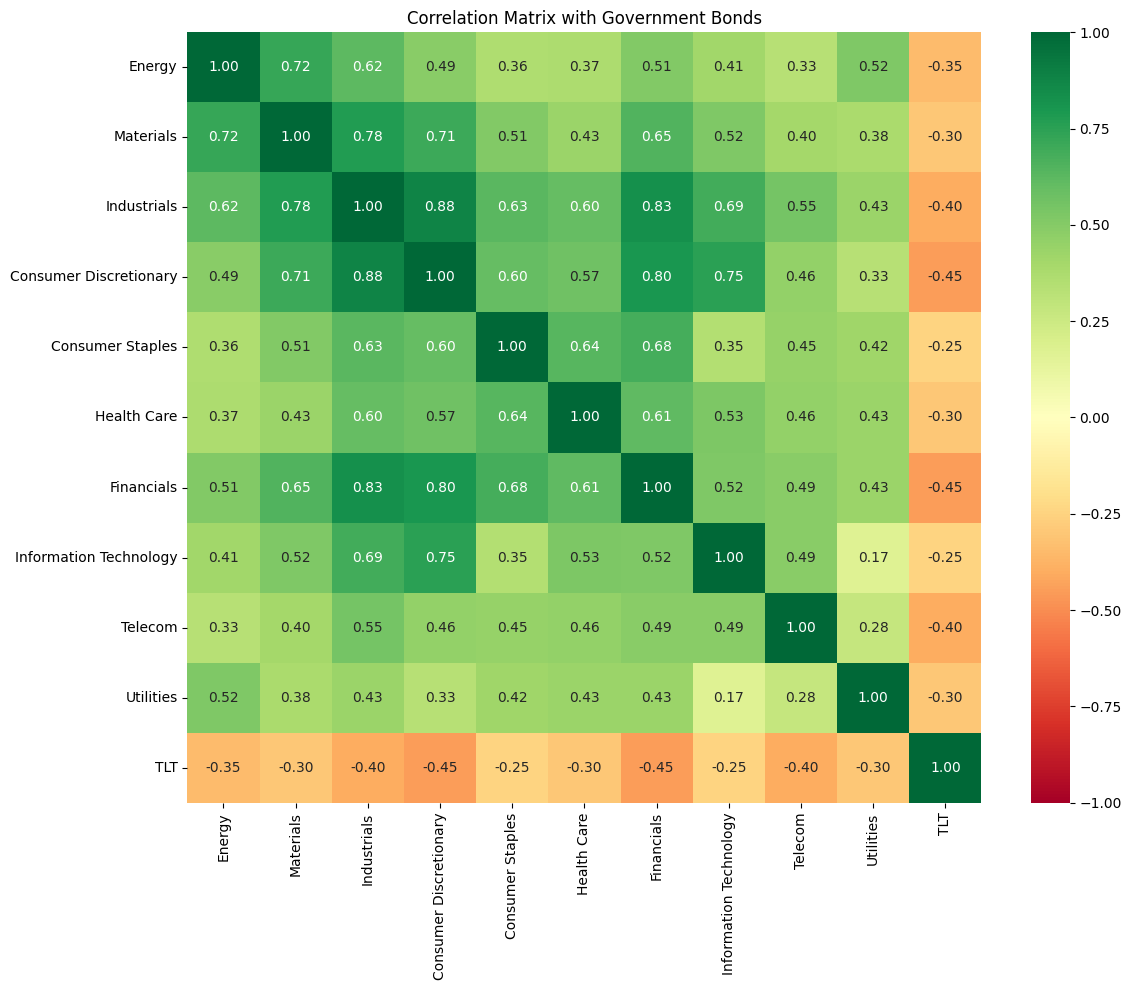

Notice the last row and column (TLT):
- Most correlations are NEGATIVE (shown in red/orange)
- This is why bonds are powerful diversifiers!
- When stocks fall, bonds often rise (negative correlation)


In [24]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(sector_corr, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1,
            xticklabels=sectors, yticklabels=sectors)
plt.title('Correlation Matrix with Government Bonds')
plt.tight_layout()
plt.show()

print("Notice the last row and column (TLT):")
print("- Most correlations are NEGATIVE (shown in red/orange)")
print("- This is why bonds are powerful diversifiers!")
print("- When stocks fall, bonds often rise (negative correlation)")

---

## Part 4: Run Optimization with Government Bonds

Now that we've added TLT to our data, let's run the optimization and see how the efficient frontier changes!

### Exercise 8: Create and Run Optimization

**Task:** Create a `MultiAssetOptimisation` object with the expanded data (including TLT) and plot the efficient frontier.

**Hint:** Use the same pattern as the baseline optimization, but now with 11 assets instead of 10.

WITH GOVERNMENT BONDS:



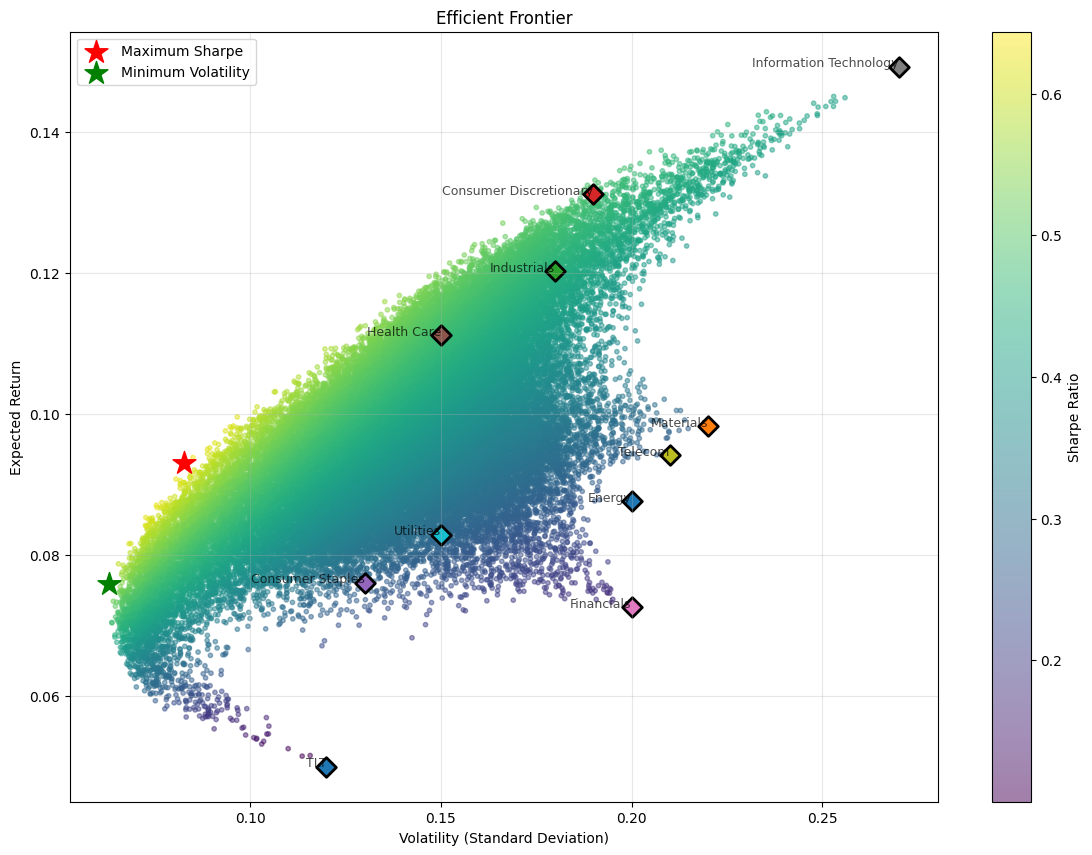

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Energy: 0.23%
Materials: 0.00%
Industrials: 1.77%
Consumer Discretionary: 29.54%
Consumer Staples: 0.00%
Health Care: 26.43%
Financials: 0.01%
Information Technology: 0.03%
Telecom: 3.19%
Utilities: 0.63%
TLT: 38.18%
Expected Return: 9.31%
Expected Volatility: 8.25%
Sharpe Ratio: 0.64

--------------------------------------------------
Minimum Volatility Portfolio Allocation

Energy: 0.53%
Materials: 0.01%
Industrials: 0.00%
Consumer Discretionary: 15.43%
Consumer Staples: 4.12%
Health Care: 4.01%
Financials: 0.13%
Information Technology: 0.00%
Telecom: 6.42%
Utilities: 20.84%
TLT: 48.50%
Expected Return: 7.60%
Expected Volatility: 6.31%
Sharpe Ratio: 0.57


In [25]:
# Exercise 8: Run optimization with government bonds
# TODO: Your code here
opt_with_bonds = MultiAssetOptimisation(
    sector_returns,
    sector_volatilities,
    sector_corr,
    sectors,
    weighting_style='dirichlet'
)

# Plot the efficient frontier
print("WITH GOVERNMENT BONDS:\n")
opt_with_bonds.plot_efficient_frontier()

---

## Part 5: Analysis Questions

Answer these questions based on your results:

### Question 1: Impact on Maximum Sharpe Ratio

Compare the **Maximum Sharpe Ratio** portfolio before and after adding bonds:

**Before (Equities Only):**
- Sharpe Ratio: 0.54
- Expected Return: 12.05%
- Volatility: 14.96%

**After (With Bonds):**
- Sharpe Ratio: 0.64
- Expected Return: 9.31%
- Volatility: 8.25%
- TLT Allocation: 38.18%

**Did the Sharpe ratio improve? Why or why not?**
the sharpe ratio improved as bonds offer a significantly lower risk, hence reduces the volatility and thus increases the sharpe ratio


### Question 2: Impact on Minimum Volatility

Compare the **Minimum Volatility** portfolio before and after adding bonds:

**Before (Equities Only):**
- Volatility: 8.34%
- Expected Return: 11.50%

**After (With Bonds):**
- Volatility: 6.31%
- Expected Return: 7.60%
- TLT Allocation: 48.50%

**Did volatility decrease? By how much?**
The volatility decreased by 2% 

### Question 3: Shape of the Efficient Frontier

**How did the shape of the efficient frontier change after adding bonds?**

Consider:
- Did it expand to the left (lower risk)?
- Did it expand upward (higher return)?
- Did it shift or rotate?

*Your answer here:*

### Question 4: Role of Negative Correlation

**Why do bonds with NEGATIVE correlations provide better diversification than bonds with positive correlations?**

Think about:
- What happens when stocks fall and bonds have negative correlation?
- How does this affect portfolio volatility?

*Your answer here:*

---

## Summary

### What You've Learned:

1. **Array Extension:**
   - Used `np.append()` to add elements to NumPy arrays
   - Extended returns and volatilities arrays

2. **Matrix Operations:**
   - Used `np.vstack()` to add rows to matrices
   - Used `np.hstack()` to add columns to matrices
   - Expanded a 10×10 correlation matrix to 11×11

3. **Financial Concepts:**
   - Government bonds as diversifiers
   - Impact of negative correlations
   - How bonds change the efficient frontier

4. **Portfolio Analysis:**
   - Compared portfolios with and without bonds
   - Analyzed changes in Sharpe ratio and volatility
   - Understood the benefit of multi-asset diversification

### Key Takeaways:

- **Negative correlations** are powerful for diversification
- **Government bonds** can reduce portfolio risk significantly
- **Matrix manipulation** is essential for portfolio optimization
- **Trade-offs exist** between return and risk reduction

**Great work completing Lab 11!** 🎉